# Fit the baseline model

## 1. Load the data


In [1]:
import pandas as pd
import keras
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import setGPU

setGPU: Setting GPU to: 1


In [2]:
data = pd.read_hdf('/bigdata/shared/AIErrorHandling/baseline_test.h5')
# HACK!! DANGER!!
#data = data.drop(data.index[16787]).drop(data.index[21352])

In [7]:
X = data['table_good_sites']

In [141]:
flt = data['tables_bad_sites_flatten']
arr = np.array(flt)
for counter, i in enumerate(flt):
    if len(i) != 8232:
        print 'OO'
        print counter

In [12]:
X = np.array(data['table_good_sites'].values.tolist())
y = np.array(data['action_binary_encoded'].values.tolist())

In [13]:
X.shape, y.shape

((25090, 58, 69), (25090,))

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## 2. Set up the model

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l1, l2
from keras.constraints import maxnorm
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

# Define Multilayer Perceptron architecture
def create_model(input_dim, nneurons, layers=[] , optimizer='adam' , loss='categorical_crossentropy' ):
    
    '''
    create_model: build neural network architecture
    '''

    # create neural network model
    model = Sequential()

    # Add fully connected layer with an activation function (input layer)
    #model.add(Dense(nneurons, input_dim=input_dim, init=kernel_initializer, activation='relu'))

    model.add(Dense(nneurons, input_dim=input_dim, activation='relu'))
    
    for layer in layers :
        nNeurons = layer[0]
        regularizer = layer[1]
        activation = layer[2]

        model.add(Dense(nNeurons,    activation=activation ) )

    model.add( Dense( 1 , activation='sigmoid' ) )


    if optimizer == "sgd" :
        Optimizer = SGD(lr=.5)
    elif optimizer == "adam":
        Optimizer =  Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
    else :
        Optimizer = optimizer
    
    model.compile(
        loss=loss ,#'categorical_crossentropy', 'mean_squared_error', 'categorical_crossentropy' 'mean_absolute_error'
        optimizer=Optimizer,
        metrics=['accuracy', auroc]
        # , 'categorical_accuracy' , top_first_categorical_accuracy(1,"kfirst"), top_first_categorical_accuracy(2,"kfirsttwo"),top_first_categorical_accuracy(3,"kfirstthree")]
    )
    
    return model
        
    
                                                                                          

In [182]:
model = create_model(len(X[0]), 20, loss='binary_crossentropy' , layers=[(20,None,'relu'),(20,None,'relu')])

In [183]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_82 (Dense)                 (None, 20)            244700      dense_input_19[0][0]             
____________________________________________________________________________________________________
dense_83 (Dense)                 (None, 20)            420         dense_82[0][0]                   
____________________________________________________________________________________________________
dense_84 (Dense)                 (None, 20)            420         dense_83[0][0]                   
____________________________________________________________________________________________________
dense_85 (Dense)                 (None, 1)             21          dense_84[0][0]                   
Total params: 245,561
Trainable params: 245,561
Non-trainable params: 0
___________________

## 3. Fit and evaluate model

In [184]:
batch_size=2000 
epochs=20
validation_split=0.25
verbose=1


res = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=validation_split )
print res

Train on 13170 samples, validate on 4391 samples
Epoch 1/20
13170/13170 [==============================] - 2s - loss: 0.6192 - acc: 0.9304 - auroc: 0.4855 - val_loss: 0.5419 - val_acc: 0.9399 - val_auroc: 0.5329
Epoch 2/20
13170/13170 [==============================] - 2s - loss: 0.5318 - acc: 0.9421 - auroc: 0.5050 - val_loss: 0.4792 - val_acc: 0.9399 - val_auroc: 0.5403
Epoch 3/20
13170/13170 [==============================] - 2s - loss: 0.4794 - acc: 0.9421 - auroc: 0.5221 - val_loss: 0.4319 - val_acc: 0.9399 - val_auroc: 0.5462
Epoch 4/20
13170/13170 [==============================] - 2s - loss: 0.4332 - acc: 0.9421 - auroc: 0.5380 - val_loss: 0.3881 - val_acc: 0.9394 - val_auroc: 0.5589
Epoch 5/20
13170/13170 [==============================] - 2s - loss: 0.3862 - acc: 0.9424 - auroc: 0.5630 - val_loss: 0.3469 - val_acc: 0.9396 - val_auroc: 0.5822
Epoch 6/20
13170/13170 [==============================] - 2s - loss: 0.3392 - acc: 0.9427 - auroc: 0.5952 - val_loss: 0.3153 - val_acc: 

In [163]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [164]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
def ROC(y_test, y_pred):
    """
    plot ROC curve for test dataset
    """
    roc_fpr, roc_tpr, roc_thresholds = roc_curve(y_test, y_pred.ravel() )
    roc_auc = auc(roc_fpr , roc_tpr)

    roc_plot = plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(roc_fpr, roc_tpr, label='Keras (area = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

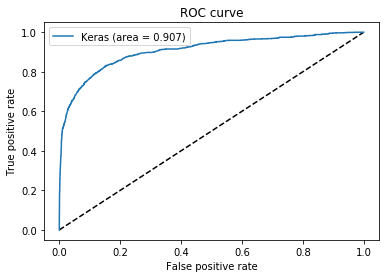

In [165]:
ROC(y_train, y_train_pred)

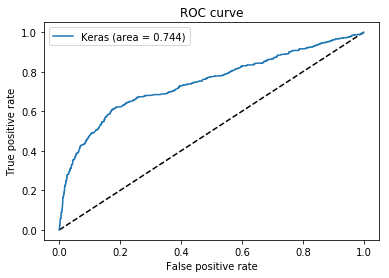

In [166]:
ROC(y_test, y_pred)

In [59]:
from keras.layers import Input, LSTM, Dense, merge
from keras.models import Model
#dim1 = len(features[0][0])
#dim2 = len(features)
dim1 = X.shape[2]

dense = Dense(100, activation = "relu", init="normal")
ip_shapes = []
op_shapes = []
for i in range(X.shape[1]):
    ip_shape = ( Input(shape=(dim1,)) )
    ip_shapes.append(ip_shape)
    op_shapes.append( dense(ip_shape))

merged_vector = merge(op_shapes, mode='concat', concat_axis=-1)

hidden1 = Dense(20, activation = "relu", init="normal")(merged_vector)
hidden2 = Dense(20, activation = "relu", init="normal")(hidden1)
#hidden3 = Dense(100, activation = "relu", init="normal")(hidden2)
#hidden4 = Dense(100, activation = "relu", init="normal")(hidden3)
# and add a logistic regression on top
predictions = Dense(1, activation='sigmoid')(hidden1)

# we define a trainable model linking the
# tweet inputs to the predictions
model = Model(input = ip_shapes, output=predictions)

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0), 
              metrics=['accuracy', auroc])

In [60]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_465 (InputLayer)           (None, 69)            0                                            
____________________________________________________________________________________________________
input_466 (InputLayer)           (None, 69)            0                                            
____________________________________________________________________________________________________
input_467 (InputLayer)           (None, 69)            0                                            
____________________________________________________________________________________________________
input_468 (InputLayer)           (None, 69)            0                                            
___________________________________________________________________________________________

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [62]:
X_train_swp = np.swapaxes(X_train,0,1)
#X_train_swp = np.swapaxes(X_train_swp,0,2)
inputs = []
for i in range(X_train_swp.shape[0]):
    inputs.append(X_train_swp[i])

In [63]:
X_train_swp.shape

(58, 17563, 69)

In [64]:
batch_size=100
epochs=20
validation_split=0.25
verbose=1
model.fit(inputs, y_train, batch_size = batch_size, nb_epoch=epochs, validation_split = validation_split)

Train on 13172 samples, validate on 4391 samples
Epoch 1/20
13172/13172 [==============================] - 3s - loss: 0.2997 - acc: 0.9287 - auroc: 0.5665 - val_loss: 0.2272 - val_acc: 0.9403 - val_auroc: 0.5547
Epoch 2/20
 7300/13172 [===============>..............] - ETA: 0s - loss: 0.2350 - acc: 0.9389 - auroc: 0.6313

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

InternalError: Failed to run py callback pyfunc_0: see error log.
	 [[Node: PyFunc = PyFunc[Tin=[DT_FLOAT, DT_FLOAT], Tout=[DT_DOUBLE], token="pyfunc_0", _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_dense_48_target_0, Sigmoid_8/_1095)]]
	 [[Node: PyFunc/_1124 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_890_PyFunc", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'PyFunc', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-59-bfa429f00f5c>", line 30, in <module>
    metrics=['accuracy', auroc])
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/training.py", line 716, in compile
    metric_result = metric_fn(y_true, y_pred)
  File "<ipython-input-18-3f29713c39ef>", line 15, in auroc
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/script_ops.py", line 192, in py_func
    input=inp, token=token, Tout=Tout, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_script_ops.py", line 40, in _py_func
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Failed to run py callback pyfunc_0: see error log.
	 [[Node: PyFunc = PyFunc[Tin=[DT_FLOAT, DT_FLOAT], Tout=[DT_DOUBLE], token="pyfunc_0", _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_dense_48_target_0, Sigmoid_8/_1095)]]
	 [[Node: PyFunc/_1124 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_890_PyFunc", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [56]:
X_test_swp = np.swapaxes(X_test,0,1)
inputs_test = []
for i in range(X_test_swp.shape[0]):
    inputs_test.append(X_test_swp[i])

y_pred = model.predict(inputs_test)
y_train_pred = model.predict(inputs)

In [57]:
print roc_auc_score(y_test, y_pred)
print roc_auc_score(y_train, y_train_pred)

0.709721019793
0.846086609063
